In [197]:
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from scipy.signal import convolve2d
from scipy.sparse import bsr_matrix, coo_matrix, dok_array, csr_matrix
from scipy.sparse.linalg import eigs, eigsh
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.manifold import TSNE
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 12})

In [183]:
# Load and preprocess data

data = sio.loadmat("./DataSets/ScienceNews.mat")

X = PCA(n_components=50).fit_transform(data['X'])

In [184]:
# Load labels and convert to one hot
labels = data['classes'][:,0]
labels = np.array(labels, dtype="int").squeeze()
Y = np.copy(labels)

chi = np.eye(9)[Y] # one-hot encode

In [185]:
def construct_adjacency_matrix(X, n, m, sigma):
    # init
    k = X.shape[0]
    W = dok_array((k, k), dtype="float")

    # nearest neighbors
    neigh = NearestNeighbors(n_neighbors=n+1, metric="euclidean").fit(X)
    dists, neighbors = neigh.kneighbors(X, return_distance=True)
    dists_norm = (dists.T/dists[:,m]).T

    # self-tuning distance
    for i in range(k):
        for j in range(1,n+1): #ignore self
            ind = neighbors[i,j]
            # calculate rho_y if not precalculated
            if i in neighbors[ind]:
                p_y = dists_norm[ind, np.argwhere(neighbors[ind]==i)]
            else:
                p_y = np.linalg.norm(X[i]-X[ind])/dists[ind, m]
            W[i, ind] = np.exp(-(dists_norm[i,j]*p_y)/sigma)
            W[ind, i] = np.exp(-(dists_norm[i,j]*p_y)/sigma) # for edge cases where a point is isolated

    # normalize 
    d = W.sum(axis=1)
    K = 1/d * W
    return K

# Diffusion

## Methods

In [186]:
def kernel_smooth(chi, K, k, s, N):
    # select labels
    inds = np.random.choice(np.arange(k), s, replace=False)

    g = np.zeros_like(chi)
    g[inds] = chi[inds]

    for i in range(N):
        for j in range(chi.shape[1]):
            g[:,j] = K@g[:,j]

    pred_Y = np.argmax(g, axis=1)
    
    return pred_Y, g

In [187]:
def harm_clf(chi, K, k, s, N):
    # select labels
    inds = np.random.choice(np.arange(k), s, replace=False)

    g = np.zeros_like(chi)
    g[inds] = chi[inds]

    for i in range(N):
        for j in range(chi.shape[1]):
            g[:,j] = K@g[:,j]
            g[inds] = chi[inds]

    pred_Y = np.argmax(g, axis=1)
    
    return pred_Y, g

## Cross-Validation

In [188]:
# split into test and train, only use train for CV
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=True, random_state=0)

### N

In [189]:
N_list = np.array([10, 12, 15, 17, 20, 30, 50, 75, 100, 150, 200, 250])
N_perf_ks = []

K = construct_adjacency_matrix(X_train, 9, 4, 1).T
chi = np.eye(10)[Y_train]

for i in range(N_list.shape[0]):
    perf = 0
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = kernel_smooth(chi, K, X_train.shape[0], 100, N_list[i])
        perf += np.mean(pred_Y == Y_train)
    N_perf_ks.append(perf/10)

In [190]:
N_list = np.array([10, 12, 15, 17, 20, 30, 50, 75, 100, 150, 200, 250])
N_perf_hc = []

for i in range(N_list.shape[0]):
    perf = 0
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, N_list[i])
        perf += np.mean(pred_Y == Y_train)
    N_perf_hc.append(perf/10)

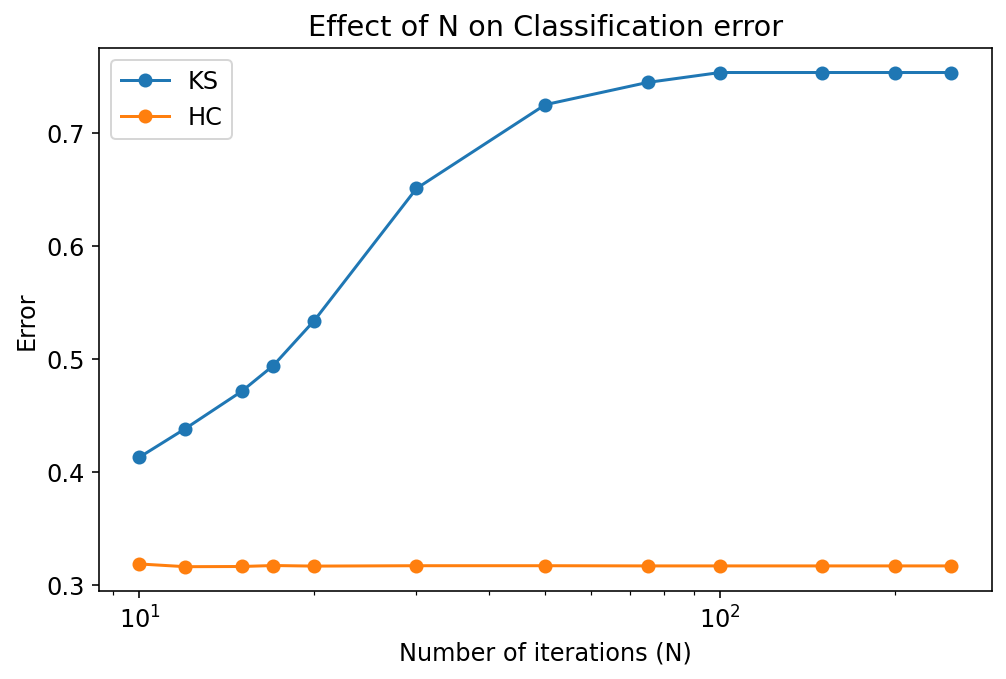

In [217]:
plt.figure(figsize = (8, 5))

plt.plot(N_list, 1-np.array(N_perf_ks), marker="o", label="KS");
plt.plot(N_list, 1-np.array(N_perf_hc), marker="o", label="HC");

plt.xscale("log"); plt.ylabel("Error"); plt.xlabel("Number of iterations (N)");
plt.title("Effect of N on Classification error"); 

plt.legend();
plt.savefig("./figures/project/Science_acc_vs_N.png")

In [192]:
N_ks = N_list[np.argmax(N_perf_ks)]
N_hc = N_list[np.argmax(N_perf_hc)]

### n, m

In [212]:
pairs = np.array([(9,4), (13,9), (15,9), (21,15)])
pairs_perf_ks = []
pairs_perf_hc = []

chi = np.eye(10)[Y_train]

for i in range(pairs.shape[0]):
    K = construct_adjacency_matrix(X_train, pairs[i,0], pairs[i,1], 1).T
    perf_ks = 0
    perf_hc = 0
    
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        
        pred_Y, g = kernel_smooth(chi, K, X_train.shape[0], 100, N_ks)
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, N_hc)
        perf_hc += np.mean(pred_Y == Y_train)
        
    pairs_perf_ks.append(perf_ks/10)
    pairs_perf_hc.append(perf_hc/10)

In [213]:
n_ks, m_ks = pairs[np.argmax(pairs_perf_ks)]
n_hc, m_hc = pairs[np.argmax(pairs_perf_hc)]

In [214]:
1 - np.array(pairs_perf_ks)

array([0.41293103, 0.45534483, 0.47224138, 0.53603448])

In [215]:
1 - np.array(pairs_perf_hc)

array([0.30689655, 0.30689655, 0.30913793, 0.31275862])

## Effect of # of labeled points

In [71]:
num_tot = np.array([200, 500, 1000])
num_lab = np.array([10, 50, 100, 250, 500, 1000])
                   
perf_ks = np.zeros((num_tot.shape[0], num_lab.shape[0]))
perf_hc = np.zeros((num_tot.shape[0], num_lab.shape[0]))

for i in range(num_tot.shape[0]):
    inds_tot = np.random.choice(np.arange(X.shape[0]), num_tot[i], replace=False)
    K_ks = construct_adjacency_matrix(X[inds_tot], n_ks, m_ks, 1).T     # CV gave same n,m for both methods
    K_hc = construct_adjacency_matrix(X[inds_tot], n_hc, m_hc, 1).T
    chi = np.eye(10)[Y[inds_tot]]
    
    
    for j in range(num_lab.shape[0]):
        if (num_lab[j] < num_tot[i]):
            temp_ks = 0
            temp_hc = 0

            for k in range(10):
                np.random.seed(k)

                pred_Y, g = kernel_smooth(chi, K_ks, X[inds_tot].shape[0], num_lab[j], N_ks)
                temp_ks += np.mean(pred_Y == Y[inds_tot])

                pred_Y, g = harm_clf(chi, K_hc, X[inds_tot].shape[0], num_lab[j], N_hc)
                temp_hc += np.mean(pred_Y == Y[inds_tot])
            
            perf_ks[i, j] = temp_ks/10
            perf_hc[i, j] = temp_hc/10

In [72]:
plt.rcParams.update({'font.size': 12})

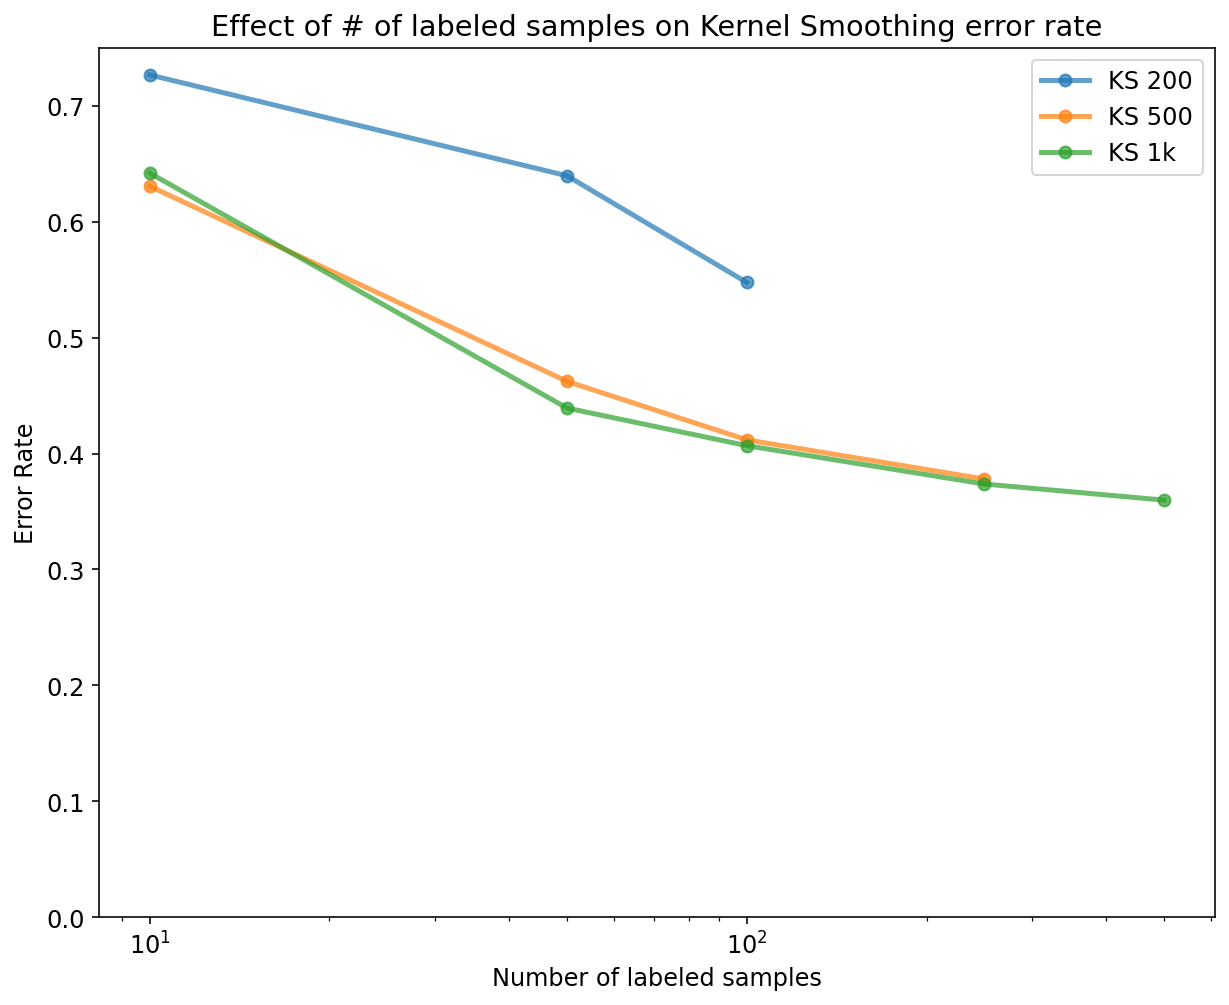

In [76]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:3], 1-perf_ks[0,:3], marker="o", label="KS 200", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:4], 1-perf_ks[1,:4], marker="o", label="KS 500", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:5], 1-perf_ks[2,:5], marker="o", label="KS 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); plt.ylim([0, .75])

plt.legend(); plt.title("Effect of # of labeled samples on Kernel Smoothing error rate");

plt.savefig("./figures/project/Science_KS_err_vs_num.png")

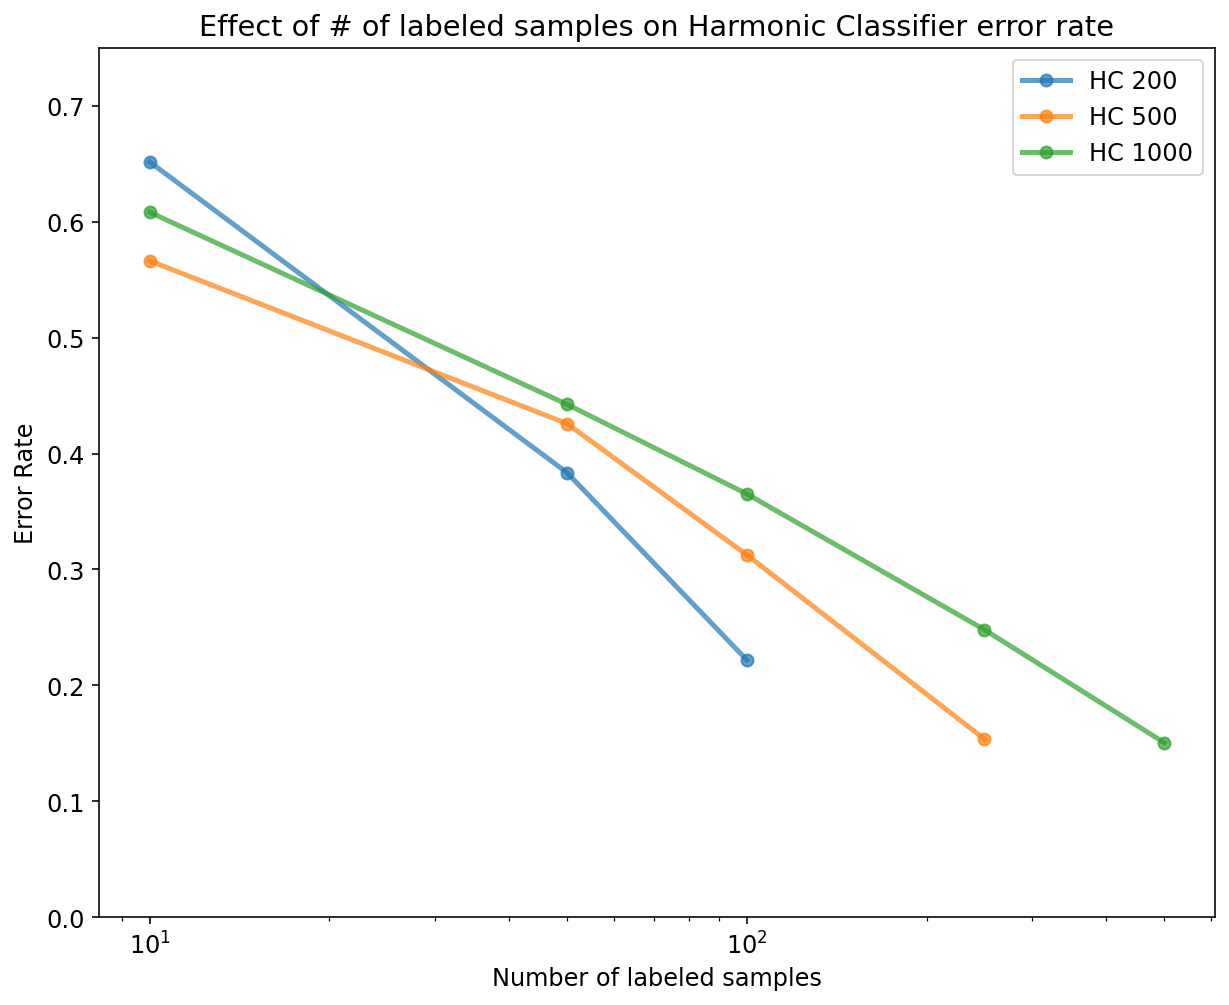

In [75]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:3], 1-perf_hc[0,:3], marker="o", label="HC 200", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:4], 1-perf_hc[1,:4], marker="o", label="HC 500", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:5], 1-perf_hc[2,:5], marker="o", label="HC 1000", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); plt.ylim([0, .75])

plt.legend(); plt.title("Effect of # of labeled samples on Harmonic Classifier error rate");

plt.savefig("./figures/project/Science_HC_err_vs_num.png")

# Function Adaptation

## Cross-Validation

### beta

In [77]:
beta = np.array([1,2,4,8])
beta_perf_ks = []
beta_perf_hc = []
chi = np.eye(9)[Y_train]

for i in range(beta.shape[0]):
    # run harm_clf for bootstrap estimate
    K = construct_adjacency_matrix(X_train, n_hc, m_hc, 1).T
    perf_ks = 0
    perf_hc = 0
    
    for j in range(10):
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, 250)

        # normalize new coords
        c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
        c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
        c *= beta[i]
        
        # run with new X
        X_train_fa = np.hstack((X_train, c))
        K_ks_fa = construct_adjacency_matrix(X_train_fa, n_ks, m_ks, 1).T
        K_hc_fa = construct_adjacency_matrix(X_train_fa, n_hc, m_hc, 1).T
        
        pred_Y, g = kernel_smooth(chi, K_ks_fa, X_train_fa.shape[0], 100, N_ks)
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K_hc_fa, X_train_fa.shape[0], 100, N_hc)
        perf_hc += np.mean(pred_Y == Y_train)
        
    beta_perf_ks.append(perf_ks/10)
    beta_perf_hc.append(perf_hc/10)
    
    print(i)

0
1
2
3


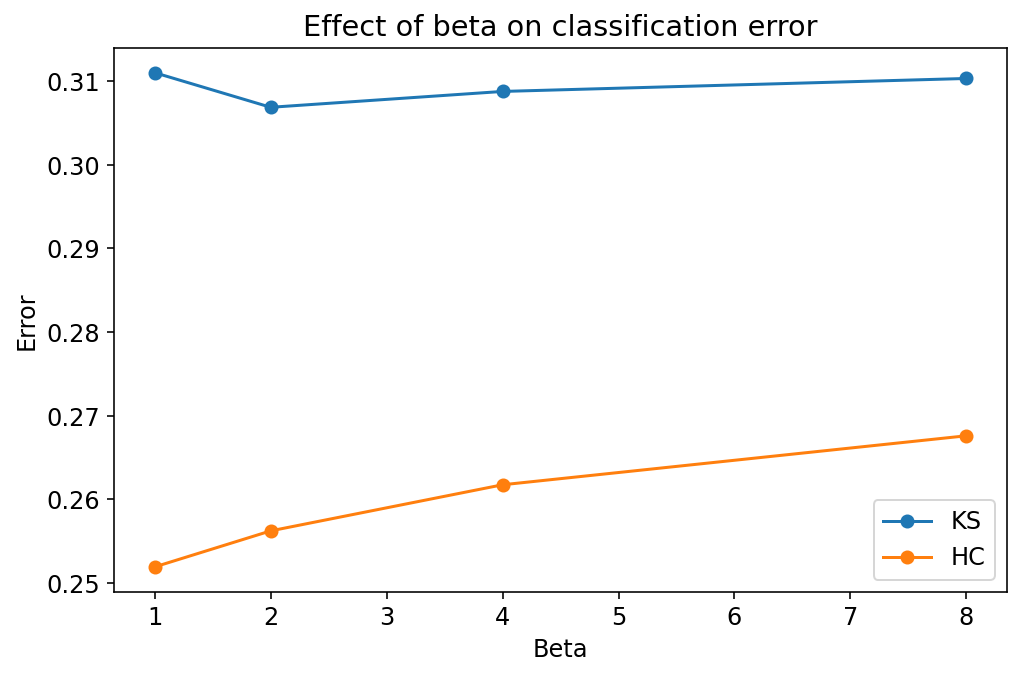

In [218]:
plt.figure(figsize = (8, 5))

plt.plot(beta, 1-np.array(beta_perf_ks), marker="o", label="KS");
plt.plot(beta, 1-np.array(beta_perf_hc), marker="o", label="HC");

plt.ylabel("Error"); plt.xlabel("Beta");
plt.title("Effect of beta on classification error"); 
plt.legend();

plt.savefig("./figures/Science_err_vs_beta.png")

In [79]:
beta_ks = beta[np.argmax(beta_perf_ks)]
beta_hc = beta[np.argmax(beta_perf_hc)]

### N

In [219]:
N_list = np.array([10, 12, 15, 17, 20, 30, 50, 75, 100, 150, 200, 250])
N_perf_ks = []
N_perf_hc = []

chi = np.eye(9)[Y_train]

for i in range(N_list.shape[0]):
    # run harm_clf for bootstrap estimate
    K_ks = construct_adjacency_matrix(X_train, n_ks, m_ks, 1).T
    K_hc = construct_adjacency_matrix(X_train, n_hc, m_hc, 1).T
    perf_ks = 0
    perf_hc = 0

    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K_hc, X_train.shape[0], 100, 250)

        # normalize new coords
        c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
        c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
        c *= beta_ks             # beta_ks = beta_hc from CV
        
        # run with new X
        X_train_fa = np.hstack((X_train, c))
        
        K_ks_fa = construct_adjacency_matrix(X_train_fa, n_ks, m_ks, 1).T
        K_hc_fa = construct_adjacency_matrix(X_train_fa, n_hc, m_hc, 1).T
        
        pred_Y, g = kernel_smooth(chi, K_ks_fa, X_train_fa.shape[0], 100, N_list[i])
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K_hc_fa, X_train_fa.shape[0], 100, N_list[i])
        perf_hc += np.mean(pred_Y == Y_train)
        
    N_perf_ks.append(perf_ks/10)
    N_perf_hc.append(perf_hc/10)

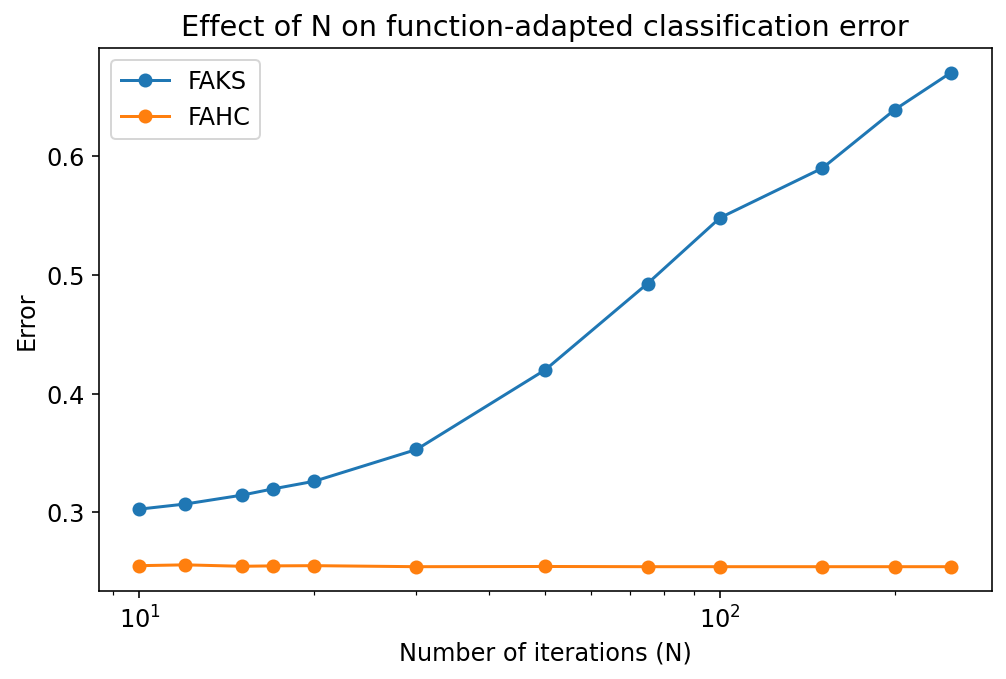

In [220]:
plt.figure(figsize = (8, 5))

plt.plot(N_list, 1-np.array(N_perf_ks), marker="o", label="FAKS");
plt.plot(N_list, 1-np.array(N_perf_hc), marker="o", label="FAHC");

plt.xscale("log"); plt.ylabel("Error"); plt.xlabel("Number of iterations (N)");
plt.title("Effect of N on function-adapted classification error"); 
plt.legend();

plt.savefig("./figures/project/Science_err_vs_N_fa.png")

In [221]:
N_ks_fa = N_list[np.argmax(N_perf_ks)]
N_hc_fa = N_list[np.argmax(N_perf_hc)]

In [222]:
print(N_ks_fa, N_hc_fa)

10 30


### n, m

In [223]:
pairs = np.array([(9,4), (13,9), (15,9), (21,15)])
pairs_perf_ks = []
pairs_perf_hc = []

chi = np.eye(9)[Y_train]

for i in range(pairs.shape[0]):
    K = construct_adjacency_matrix(X_train, pairs[i,0], pairs[i,1], 1).T
    perf_ks = 0
    perf_hc = 0
    
    for j in range(10):          # random sets of labeled points
        np.random.seed(j)
        pred_Y, g = harm_clf(chi, K, X_train.shape[0], 100, 250)

        # normalize new coords
        c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
        c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
        c *= beta_ks             # beta_ks = beta_hc from CV
        
        # run with new X
        X_train_fa = np.hstack((X_train, c))
        K_fa = construct_adjacency_matrix(X_train_fa, pairs[i,0], pairs[i,1], 1).T
        
        pred_Y, g = kernel_smooth(chi, K_fa, X_train_fa.shape[0], 100, N_ks_fa)
        perf_ks += np.mean(pred_Y == Y_train)
        
        pred_Y, g = harm_clf(chi, K_fa, X_train_fa.shape[0], 100, N_hc_fa)
        perf_hc += np.mean(pred_Y == Y_train)
        
    pairs_perf_ks.append(perf_ks/10)
    pairs_perf_hc.append(perf_hc/10)

In [224]:
n_ks_fa, m_ks_fa = pairs[np.argmax(pairs_perf_ks)]
n_hc_fa, m_hc_fa = pairs[np.argmax(pairs_perf_hc)]

In [225]:
1 - np.array(pairs_perf_ks)

array([0.30241379, 0.30465517, 0.31327586, 0.33517241])

In [226]:
1 - np.array(pairs_perf_hc)

array([0.26      , 0.25431034, 0.25327586, 0.25310345])

## Effect of # of labeled points

In [108]:
num_tot = np.array([200, 500, 1000])
num_lab = np.array([10, 50, 100, 250, 500, 1000])
                   
perf_ks = np.zeros((num_tot.shape[0], num_lab.shape[0]))
perf_hc = np.zeros((num_tot.shape[0], num_lab.shape[0]))

for i in range(num_tot.shape[0]):
    # run harm_clf for bootstrap estimate
    inds_tot = np.random.choice(np.arange(X.shape[0]), num_tot[i], replace=False)
    K = construct_adjacency_matrix(X[inds_tot], n_hc_fa, m_hc_fa, 1).T     # CV gave same n,m for both methods
    chi = np.eye(9)[Y[inds_tot]]
    
    for j in range(num_lab.shape[0]):
        if (num_lab[j] < num_tot[i]):
            temp_ks = 0
            temp_hc = 0

            for k in range(10):
                np.random.seed(k)
                pred_Y, g = harm_clf(chi, K, X[inds_tot].shape[0], 100, 250)

                # normalize new coords
                c = g/(np.abs(g).sum(axis=0)[np.newaxis,:])
                c *= np.mean(np.linalg.norm(X, axis=1))/np.mean(np.linalg.norm(c, axis=1))
                c *= beta_ks             # beta_ks = beta_hc from CV

                # run with new X
                X_test_fa = np.hstack((X[inds_tot], c))
                
                K_ks_fa = construct_adjacency_matrix(X_test_fa, n_ks_fa, m_ks_fa, 1).T
                K_hc_fa = construct_adjacency_matrix(X_test_fa, n_hc_fa, m_hc_fa, 1).T

                pred_Y, g = kernel_smooth(chi, K_ks_fa, X_test_fa.shape[0], num_lab[j], N_ks_fa)
                temp_ks += np.mean(pred_Y == Y[inds_tot])

                pred_Y, g = harm_clf(chi, K_hc_fa, X_test_fa.shape[0], num_lab[j], N_hc_fa)
                temp_hc += np.mean(pred_Y == Y[inds_tot])
            
            perf_ks[i, j] = temp_ks/10
            perf_hc[i, j] = temp_hc/10

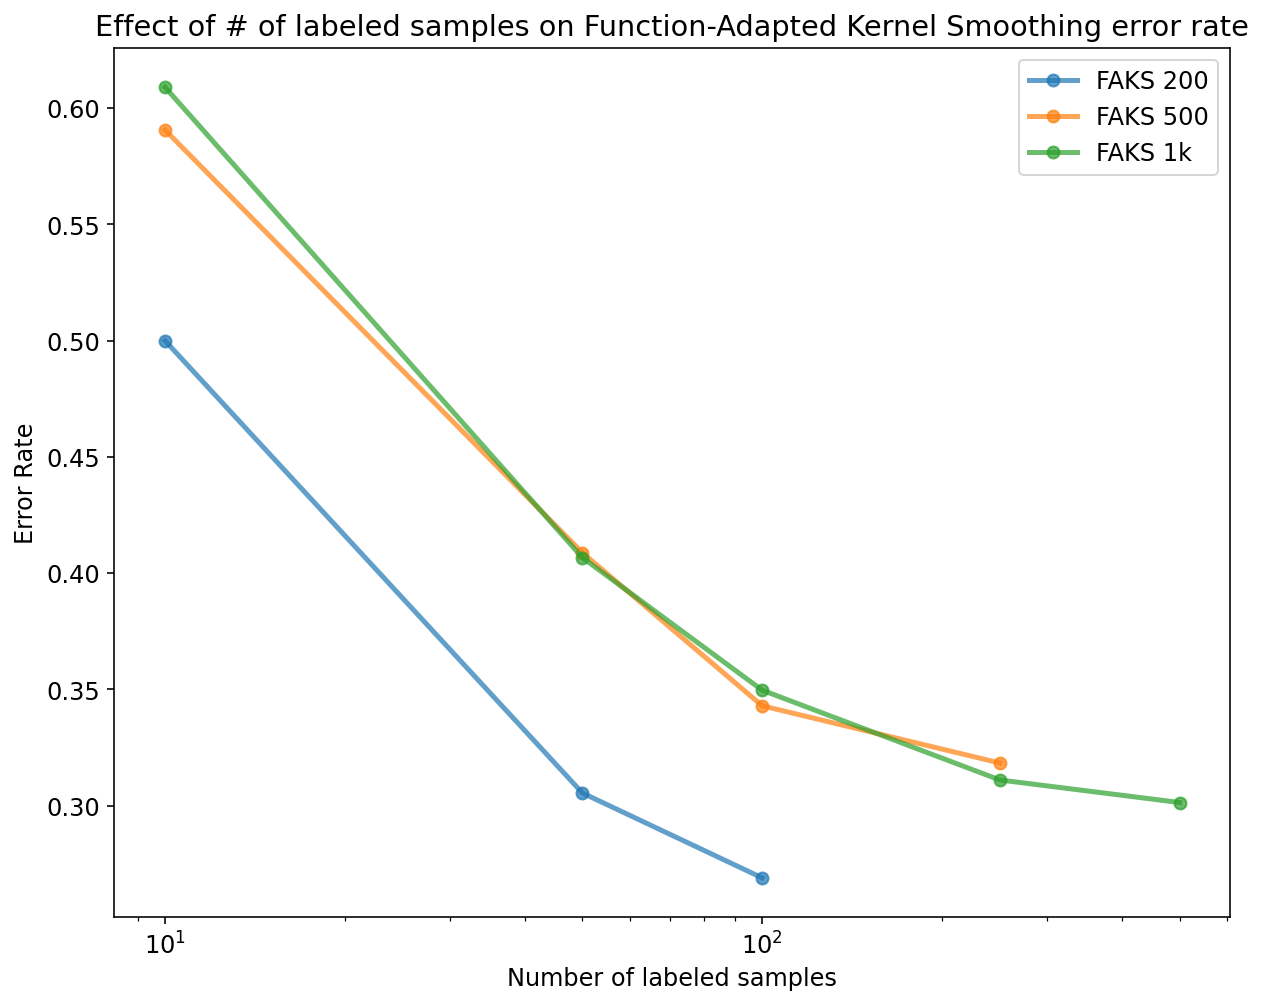

In [113]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:3], 1-perf_ks[0,:3], marker="o", label="FAKS 200", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:4], 1-perf_ks[1,:4], marker="o", label="FAKS 500", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:5], 1-perf_ks[2,:5], marker="o", label="FAKS 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); 
# plt.ylim([0, .59])

plt.legend(); plt.title("Effect of # of labeled samples on Function-Adapted Kernel Smoothing error rate");

plt.savefig("./figures/project/Science_FAKS_err_vs_num.png")

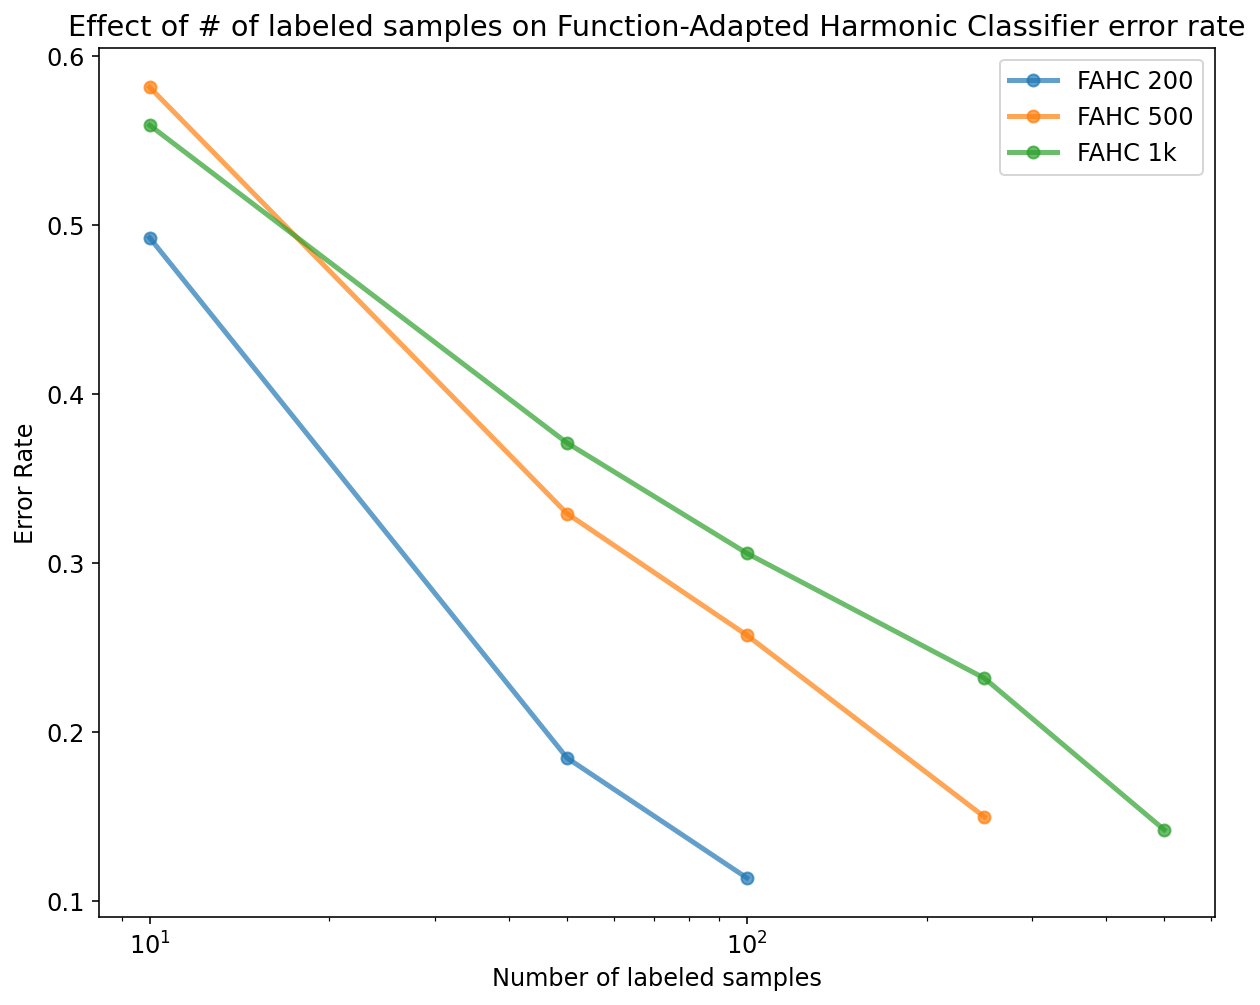

In [112]:
plt.figure(figsize = (10, 8))
plt.plot(num_lab[:3], 1-perf_hc[0,:3], marker="o", label="FAHC 200", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:4], 1-perf_hc[1,:4], marker="o", label="FAHC 500", alpha=0.7, linewidth=2.5); plt.xscale("log")
plt.plot(num_lab[:5], 1-perf_hc[2,:5], marker="o", label="FAHC 1k", alpha=0.7, linewidth=2.5); plt.xscale("log")

plt.xlabel("Number of labeled samples"); plt.ylabel("Error Rate"); 
# plt.ylim([0, .59])

plt.legend(); plt.title("Effect of # of labeled samples on Function-Adapted Harmonic Classifier error rate");

plt.savefig("./figures/project/Science_FAHC_err_vs_num.png")

# T-SNE

In [195]:
x_tsne = TSNE().fit_transform(X)

/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [198]:
df = pd.DataFrame({"tsne_1": x_tsne[:,0],
                   "tsne_2": x_tsne[:,1],
                   "class": Y})

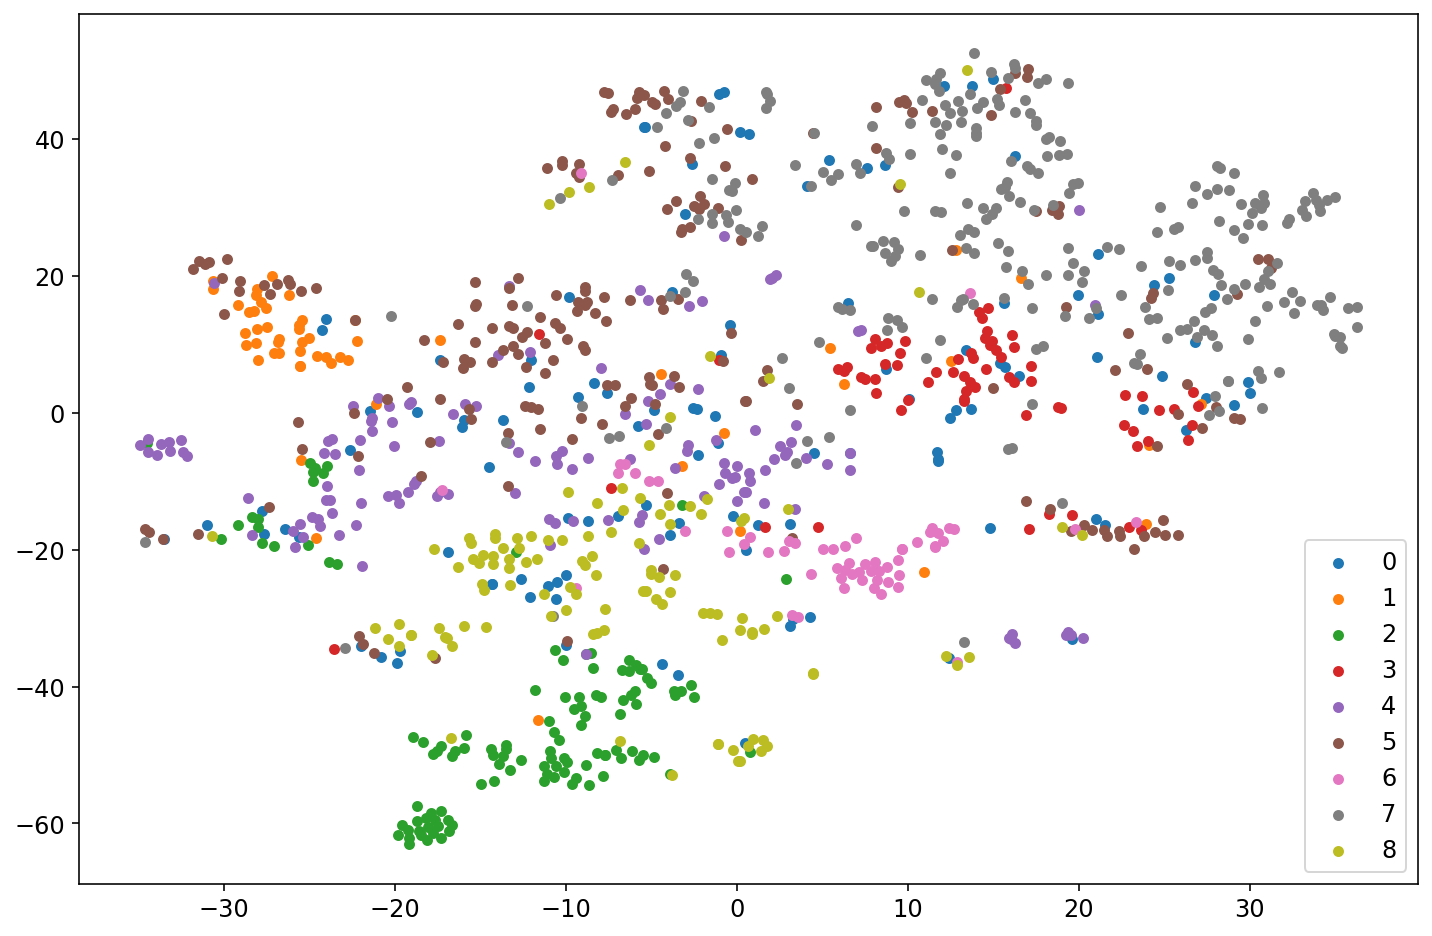

In [210]:
groups = df.groupby("class")
plt.figure(figsize=(12,8))

for name, group in groups:
    plt.scatter(group.tsne_1, group.tsne_2, s=20, label=name)
    
plt.legend();